CTR Predictor basics
--------------------
This is a very simple tutorial that covers creating/using CTR predictor based on two features (Domain, OS), loading model in your code, and predicting CTR in your code. 

Prediction step of some of the ML models are very trivial (find a sum, apply a simple formula). Using third-party libraries/services can have a lot of overhead (jni,  serialization/deserialization, running 3p daemons, and, most enjoyable, debugging 3rd-party daemons under high load). And making inference inside of your app makes a lot of sense. 

I also describe how to do feature encoding in a convenient way from the point of software engineering, and how to make sure that there is no magic. 

What's not covered here is a choice of features and creation of a new ones (features). I also didn't cover negative downsampling (which typically allows to handle 100x less data). 

Let's load some libs, and some data (data in a table format: domain, OS, and wether there was or there was no click).

In [2]:
import numpy as np
import pandas as pd
import mmh3
import seaborn as sns
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt

In [4]:
!ls -ltr *.json

-rw-r--r--  1 igworx  staff  106166469 Dec 30 14:54 ctr_dataset.json


In [9]:
df = pd.read_json('ctr_dataset.json').reset_index()

In [10]:
df.head()

,index,Clicks,Domain,OS
0,0,0,HappyGoodall.com,Android
1,1,0,ZealousLamport.com,Windows
2,10,0,DazzlingPike.com,Windows
3,100,0,HopefulHawking.com,Android
4,1000,0,VibrantHeisenberg.com,Windows


In [18]:
print 'Total clicks:', df.Clicks.sum()
print 'Total lines:', len(df.Clicks)

Total clicks: 15623
Total lines: 1747637


In [19]:
print 'Average CTR in a dataset', df.Clicks.sum()/float(len(df.Clicks))

Average CTR in a dataset 0.00893949944983


I'm making train/test split by assigning *first 80%* of lines to train, and *the last 20%* to test set (assuming they are sorted by timestamps).
This way, test set performance will be a better indication of how predictor will fare in prod, since test set might contain new values of categorical variables, that were not seen before. 

My recommendation, when you develop basic predictors in adtech, to not do a random split, since that will leak future information to the predictor. (Obvious, but just in case.) Another painfully obvious thing is that you can safely shuffle train/test sets after a split. 

Logistic regression inference is very simple:

$ŷ = Sigmoid ( a_0x_0 + a_1x_1 + ... a_nx_n +b )$

Where Simoid is simply a function we use to map values to the interval from 0 to 1: 
$Sigmoid(x) = \frac{1}{1+e^{-x}}  $

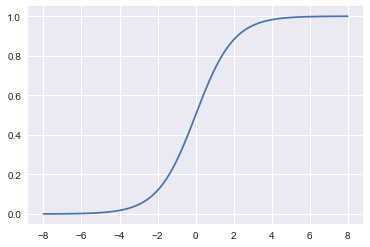

In [16]:
def sigmoid(x):
    return 1./(1.+np.exp(-x))

x = np.linspace(-8.,8.,100)
plt.plot(x,sigmoid(x))

If $x_1, x_2, .. x_n$ would only take values of zero and one, it'll make our lives much easier when we'll predict something: because if $x_n$ is 0, weights don't matter. And inference step becomes trivial: we simply sum up weights for non-zero features, and apply sigmoid function.

Now, how do we go from  a table  to a list of bit strings?

| Domain | OS |
|------|------|
| example1.com | Desktop | 
| exmple2.com | Desktop | 
| exmple3.com | Desktop | 
| exmple3.com | Mobile | 


Simple thing to do is to use dummy encoding, by encoding every value of categorical variable (e.g. domain name) into it's own integer value. For example: 
Domain_example1.com -> 0
Device_type_Desktop -> 1
Domain_example2.com -> 2
Domain_example3.com -> 3
Device_type_Mobile -> 4

And this way, we can represent our table as a list of bit strings:

| Domain | OS | Encoded |
|------|------|------| 
| example1.com | Desktop | 00011 |
| exmple2.com | Desktop | 00101 | 
| exmple3.com | Desktop | 01001 |
| exmple3.com | Mobile |  11000 |

When we have a lot of possible values e.g. 1m different domain, and one million bits, with just two set on every line. This line 000000000100000000100 can be come very sparse. And the easiest way to encode sparce bit array is simply by listing indices of non-zero elements.  

| Domain | OS | Encoded | Set bit indices |
|------|------|------|------|
| example1.com | Desktop | 00011 | 0,1| 
| exmple2.com | Desktop | 00101 | 0,2|
| exmple3.com | Desktop | 01001 | 0,3|
| exmple3.com | Mobile |  11000 | 3,4|


That'll work. However, most of the time we don't really care about having backward mapping of features (from indices to their names), and we simply can hash features into a really big space (like, 2^22-2^26...). 

It's like a hash table with a table size we define on start, and the values are either 0 or 1. If space (table size) is sufficiently large, and the hash function works well, the collisions are rare. 

And even when there are collisions, it only improves model generalization. 

This obviously cannot be called anything else but hashing trick. 

VW does its own hashing trick (using one of murmurhash version); but for a better control over hash func we'll prepare data ourselves. 

VW also has a magical value for a constant (intercept), but to make sure there is no magic, we'll have a special id (const).

In [20]:
space = 2**24 # our space
mod = space - 1 # but we won't use one value, because we want to have place for intercept
const = mod 

Let's hash individual variables 

In [21]:
df['Domain_hash'] = df.Domain.apply(lambda x: (mmh3.hash("domain_"+x, signed=False) % mod))
df['OS_hash'] = df.OS.apply(lambda x: (mmh3.hash("hash_"+x, signed=False) % mod))
df['Intersection_hash'] = df.apply(lambda x: mmh3.hash("intersection_%s_%s" % (x.Domain, x.OS), signed=False) % mod, axis=1)

And now, let's generate data in VW format. If you are going to use pipeline similar to described here, I encourage you to handle the format string with care (spaces matter). 

The format, simplified, is as following:

label | feature1 feature2 feature3 ... 

The "features" that we feed into VW, are simply indices for our non-zero features. 
The label is "1" for positive example (click), and "-1" for negative example: the absence of a click.

In [22]:
clicks=["-1","1"]
def VowpalWabbitFormat(x):
    return "%s | %d %d %d %d" % (clicks[x.Clicks], x.Domain_hash, x.OS_hash, x.Intersection_hash, const)

df['VW'] = df.apply(VowpalWabbitFormat, axis=1)

In [23]:
df.head()

,index,Clicks,Domain,OS,Domain_hash,OS_hash,Intersection_hash,VW
0,0,0,HappyGoodall.com,Android,12233527,2670727,16026914,-1 | 12233527 2670727 16026914 16777215
1,1,0,ZealousLamport.com,Windows,2155948,5721293,7606037,-1 | 2155948 5721293 7606037 16777215
2,10,0,DazzlingPike.com,Windows,7552272,5721293,14139854,-1 | 7552272 5721293 14139854 16777215
3,100,0,HopefulHawking.com,Android,6885255,2670727,16441169,-1 | 6885255 2670727 16441169 16777215
4,1000,0,VibrantHeisenberg.com,Windows,3384234,5721293,7935879,-1 | 3384234 5721293 7935879 16777215


We'll use Vowpal Wabbit here for stability and effectiveness of their SGD implementation. This is almost perfect tool for first take on production-ready ML. 

In [24]:
train = df[0:int(len(df)*0.8)]
test = df[int(len(df)*0.8):]

In [40]:
mean_train_ctr = float(train.Clicks.sum())/float(len(train))
mean_train_ctr

0.008892010565699814

Saving data in VW format to disk

In [25]:
train.VW.to_csv('train.vw', header=False, index=False)
test.VW.to_csv('test.vw', header=False, index=False)

Let's train VW! 

| Parameter | Description   |
|------|------|
|  -f    | model filename |
|  --readable_model    | readable model filename |
|  --loss_function    |  loss function for learning (in our case, logistic regression)  |
|  --hash strings   |  we only hash features that look like strings; everything numeric presumed to be already hashed  |
| -b | our hashing space |
| --noconstant | do not use intercept: otherwise VW will add intercept at a magical index |  


In [26]:
#train
!rm model.vw
!rm model.txt
!vw train.vw -f model.vw --readable_model model.txt --loss_function logistic --hash strings -b 24 --noconstant

final_regressor = model.vw
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000        4
0.646099 0.599051            2            2.0  -1.0000  -0.1980        4
0.545920 0.445742            4            4.0  -1.0000  -0.6257        4
0.448676 0.351432            8            8.0  -1.0000  -0.6945        4
0.332870 0.217064           16           16.0  -1.0000  -1.5828        4
0.236141 0.139411           32           32.0  -1.0000  -2.1487        4
0.152060 0.067980           64           64.0  -1.0000  -2.8825        4
0.095498 0.038935          128          128.0  -1.0000  -4.2980        4
0.108724 0.121950          256          256.0  -1.0000  -3.4444        4
0.078629 0.048534          512          51

In [27]:
!head -n20 model.txt

Version 8.7.0
Id 
Min label:-50
Max label:50
bits:24
lda:0
0 ngram:
0 skip:
options: --hash strings
Checksum: 428910861
:0
1252:-1.04228
4893:-1.61656
10593:-0.510001
13163:0.0826358
16809:-1.85865
19229:-1.43742
20317:-1.54855
23551:-0.751467
23782:-0.73655


In [28]:
X_test = test.apply(lambda x: [x.Domain_hash,x.OS_hash, x.Intersection_hash], axis=1)
X_test = X_test.values.tolist()

This is predictor implementation sans error checks. 

In [29]:
class LogisticRegressionPredictor:
    def __init__(self, space, const):
        self.space = space
        self.const = const
        self.weights=np.zeros(space)
        
    def load_model(self, filename):
        text_model = open(filename)
        k = 0
        for i,l in enumerate(text_model):
            if i<11: # we simply pray that we don't need first 10 lines 
                continue
            k+=1
            w = l.strip().split(':')
            self.weights[int(w[0])]= float(w[1])
        text_model.close()
        
    #features: array of arrays, w/o const, we'll add it in
    def predict(self, X):
        y_hat = []
        for features in X:
            s = self.weights[const]
            for f in features:
                s+= self.weights[f]
            r = sigmoid(s)
            y_hat.append(r)
        return y_hat
    

Let's load a model from file on disk, and make our predcitions for the test split!

In [30]:
lr = LogisticRegressionPredictor(space, const)
lr.load_model('model.txt')
preds_loaded_model = lr.predict(X_test)
preds_loaded_model = pd.DataFrame({'preds_internal': preds_loaded_model})

Let's make predictions with vw

In [31]:
!vw test.vw -t -i model.vw  --loss_function logistic --hash strings -b 24 --noconstant --link=logistic -p preds.txt

only testing
predictions = preds.txt
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.007766 0.007766            1            1.0  -1.0000   0.0077        4
0.005835 0.003904            2            2.0  -1.0000   0.0039        4
0.006280 0.006725            4            4.0  -1.0000   0.0014        4
0.008947 0.011615            8            8.0  -1.0000   0.0002        4
0.006260 0.003573           16           16.0  -1.0000   0.0047        4
0.007259 0.008259           32           32.0  -1.0000   0.0233        4
0.005987 0.004715           64           64.0  -1.0000   0.0003        4
0.009460 0.012932          128          128.0  -1.0000   0.0001        4
0.009815 0.010171          256          256.0  -1.0000   0.0001        4
0.015831 0.021847          512   

Let's load VW's predictions

In [32]:
preds_vw = pd.read_csv('preds.txt', names=['preds'])

In [33]:
res = pd.DataFrame({
 'Clicks': test.Clicks.values,
 'PredsVW': preds_vw.preds,
 'PredsInt': preds_loaded_model.preds_internal
})

And let's make sure that they are exactly the same as what we predicted. 

In [34]:
DiffDueToMagic = (res.PredsInt-res.PredsVW).abs().sum()/float(len(res))
print "DiffDueToMagic", DiffDueToMagic

DiffDueToMagic 2.45360775203e-07


And that is a VERY small value. Let's now calculate the average CTRs for baseline predictors:

In [35]:
domain_ctr = train.groupby('Domain_hash')['Clicks'] .agg(('count', 'size', 'mean', 'sum')).reset_index()
OS_ctr = train.groupby('OS_hash')['Clicks'] .agg(('count', 'size', 'mean', 'sum')).reset_index()
intersection_ctr = train.groupby('Intersection_hash')['Clicks'] .agg(('count', 'size', 'mean', 'sum')).reset_index()

In [36]:
domain_ctr.head()

,Domain_hash,count,size,mean,sum
0,4893,45,45,0.000000,0
1,10593,67,67,0.044776,3
2,19229,23,23,0.000000,0
3,23551,647,647,0.026275,17
4,23782,13,13,0.076923,1


Now, lets make predictions using our esitmators, and put it into a single table for convenience.

In [41]:
def lookup(tbl, column_name, val):
    l = tbl[tbl[column_name]==val]['mean'].values.tolist()
    if len(l)==0:
        return mean_train_ctr
    return l[0]

In [42]:
ctr_pred_by_domain = test.apply(lambda x: lookup(domain_ctr, 'Domain_hash', x.Domain_hash) ,axis=1).values
ctr_pred_by_intersect = test.apply(lambda x: lookup(intersection_ctr, 'Intersection_hash', x.Intersection_hash) ,axis=1).values
ctr_pred_by_device_type = test.apply(lambda x: lookup(OS_ctr, 'OS_hash', x.OS_hash) ,axis=1).values

In [43]:
res = pd.DataFrame({
 'Clicks': test.Clicks.values,
 'PredsVW': preds_vw.preds,
 'PredsInt': preds_loaded_model.preds_internal,
 'PredsDomain': ctr_pred_by_domain,
 'PredsOS': ctr_pred_by_device_type,    
 'PredsIntersect': ctr_pred_by_intersect
})

In [44]:
res.head()

,Clicks,PredsDomain,PredsInt,PredsIntersect,PredsOS,PredsVW
0,0,0.006774,0.007735,0.006774,0.006263,0.007735
1,0,0.003254,0.003896,0.003254,0.011643,0.003896
2,0,0.010139,0.011956,0.010139,0.011643,0.011956
3,0,0.001031,0.001420,0.001031,0.006263,0.001420
4,0,0.016148,0.020356,0.016148,0.011643,0.020356


And finally, let's look at predictor performance!

In [45]:
for pred_source in ['PredsDomain', 'PredsInt', 'PredsIntersect', 'PredsOS']:
    roc_auc = roc_auc_score(res.Clicks, res[pred_source])
    ll = log_loss(res.Clicks, res[pred_source])
    err = (res.Clicks.sum() - res[pred_source].sum())/res.Clicks.sum()
    rmse = np.sqrt(np.power((res.Clicks-res[pred_source]),2).sum()/float(len(res.Clicks)))
    print "Pred: %s ROC AUC: %f, Log Loss: %f, Err: %f, RMSE: %f" % ( pred_source, roc_auc, ll, err, rmse )

Pred: PredsDomain ROC AUC: 0.818966, Log Loss: 0.056889, Err: 0.028590, RMSE: 0.093805
Pred: PredsInt ROC AUC: 0.838927, Log Loss: 0.043879, Err: -0.049233, RMSE: 0.093592
Pred: PredsIntersect ROC AUC: 0.818966, Log Loss: 0.056889, Err: 0.028590, RMSE: 0.093805
Pred: PredsOS ROC AUC: 0.573714, Log Loss: 0.051688, Err: 0.025731, RMSE: 0.095077


The main conclusion I draw here is that test data could much more illustrating that that. 

But there are a couple of interesting results: first, it's clear that OS is quite useless. 

And logistic regression outperofrms simple domain-based CTR estimator, as well as estimator that is based on two variables. With increase in a number of variables and amount of data, it'll do much better.